# Chronological Attribution of ancient texts using deep NNs

In [1]:
import pandas as pd
import numpy as np
import sys
import os

import matplotlib.pyplot as plt
import data_explore
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

import keras
from keras.optimizers import SGD

import torch
import torch.nn as nn


from datetime import datetime
from time import time

import warnings
warnings.filterwarnings("ignore")



In [2]:
# Start time of Execution
time_start = time()

### Data Exploration & Preprocessing

In [3]:
# Retrieve data in DataFrame format
data = pd.read_csv('iphi2802.csv', sep= '\t')
df = pd.DataFrame(data)
# df = df.drop(columns=['id', 'metadata', 'date_str', 'date_circa', 'region_main', 'region_sub'])

#### Exploratory Data Analysis

In [4]:
df.head()

,id,text,metadata,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
0,315181,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,Boiotia — Thespiai — mid-3rd c. BC — BCH 26 (1...,1698,Central Greece (IG VII-IX),1691,"Megaris, Oropia, and Boiotia (IG VII)",mid-3rd c. BC,-275.0,-226.0,0.0
1,201686,μαλκοιδων ηρωνος.,"Crete, W. — Tarrha — 1st-3rd c. AD — IC II xxi...",1699,"Aegean Islands, incl. Crete (IG XI-[XIII])",474,Crete,1st-3rd c. AD,1.0,300.0,0.0
2,153178,βασιλικος.,Makedonia (Bottiaia) — Pella — 3rd/2nd c. BC —...,1692,Northern Greece (IG X),1485,Macedonia,3rd/2nd c. BC,-300.0,-101.0,0.0
3,28582,αισκλαπιει μ [ανεθεκε --].,Epidauria — Epidauros — sinistr. — 6th/5th c. BC,1690,Peloponnesos (IG IV-[VI]),1643,"Epidauria (IG IV²,1)",6th/5th c. BC,-600.0,-401.0,0.0
4,333620,[---]ος αν[εθηκε δαματρι].,Italia — Herakleia (Policoro) — late 4th/early...,1696,"Sicily, Italy, and the West (IG XIV)",1689,"Italy, incl. Magna Graecia",late 4th/early 3rd c. BC,-350.0,-251.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2802 non-null   int64  
 1   text            2802 non-null   object 
 2   metadata        2802 non-null   object 
 3   region_main_id  2802 non-null   int64  
 4   region_main     2802 non-null   object 
 5   region_sub_id   2802 non-null   int64  
 6   region_sub      2802 non-null   object 
 7   date_str        2802 non-null   object 
 8   date_min        2802 non-null   float64
 9   date_max        2802 non-null   float64
 10  date_circa      2802 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 240.9+ KB


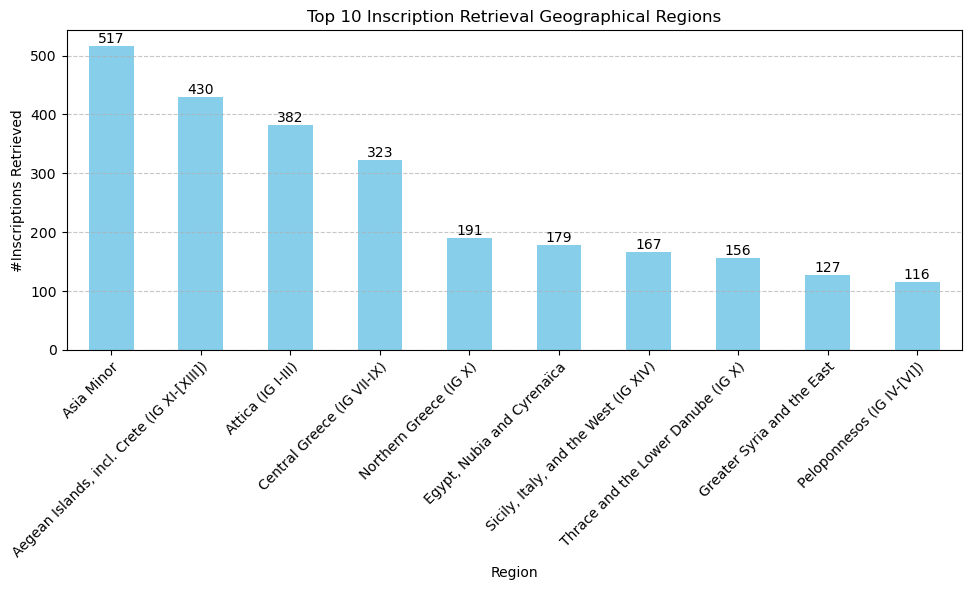

In [6]:
# Locations' dictionaries
region_main_dict = {key: value for key, value in zip(df['region_main_id'], df['region_main'])}
region_sub_dict = {key: value for key, value in zip(df['region_sub_id'], df['region_sub'])}
region_dict = {
    'region_main_dict': region_main_dict,
    'region_sub_dict': region_sub_dict
}
# Plot epigraph location frequency histogram
plt.figure(figsize=(10, 6))
bars = df['region_main_id'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Inscription Retrieval Geographical Regions')
plt.xlabel('Region')
plt.ylabel('#Inscriptions Retrieved')
plt.xticks(range(len(df['region_main_id'].value_counts().head(10))), [region_main_dict[key] for key in df['region_main_id'].value_counts().head(10).index], rotation=45, ha='right', rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.tight_layout()

plt.show()

#### Data Preprocessing - Text Encoding (Tokenization/Vectorization) / Scaling

In [7]:
# extracting features - predictors
text = df['text'].tolist()
region_main = df['region_main_id']
region_sub = df['region_sub_id']
# extracting labels
date_min  = df['date_min'].tolist()
date_max = df['date_max'].tolist()

# for usage on determing the features' selection in vectorization using ANOVA
df = df.assign(date_mean=(df['date_min'] + df['date_max']) / 2)
date_mean = df['date_mean']

labels_df = pd.DataFrame({
    'date_min': date_min,
    'date_max': date_max
})

In [8]:
text[0]

'[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισιας εποιησε.'

Average number of words per sample: 7.0
Total number of ngrams: 81315


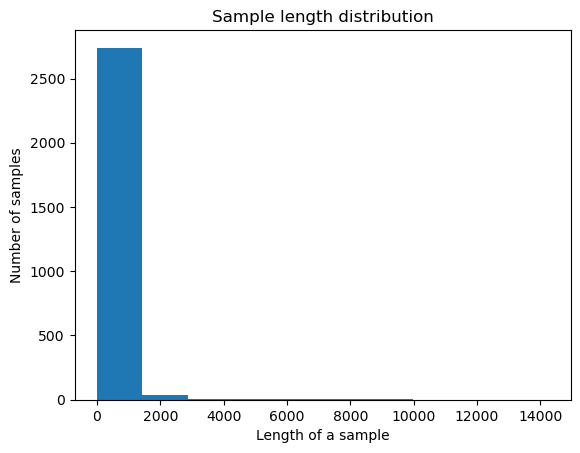

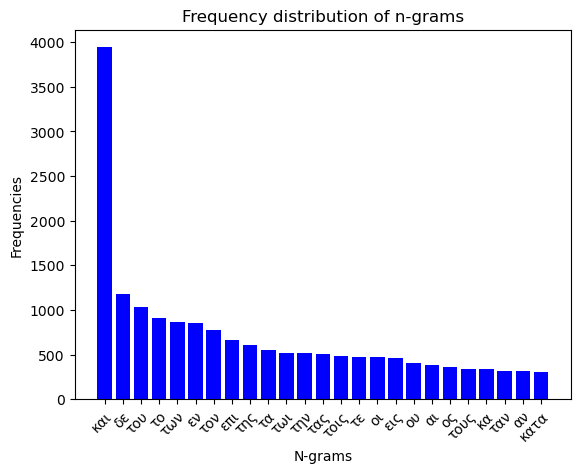

In [9]:
ave, ngrams = data_explore.get_num_words_per_sample(text)
print(f'Average number of words per sample: {ave}')
print(f'Total number of ngrams: {ngrams}')

# plot sample length distribution
data_explore.plot_sample_length_distribution(text)

# plot frequency distribution of ngrams
data_explore.plot_frequency_distribution_of_ngrams(text)

In [10]:
print(f'Total Samples / Average Number of Words per Sample = {2802/ave:.2f}')

Total Samples / Average Number of Words per Sample = 400.29


In [11]:
# Split data
X_train, X_test, labels_train, labels_test = train_test_split(text, labels_df, test_size=.3, random_state=42) 

In [12]:
# Text vectorization
X_train_vect, X_test_vect = utils.ngram_vectorize(X_train, X_test)


Tokens[:40]: ['αα' 'αγ' 'αγα' 'αγαθ' 'αγαθα' 'αγαθαι' 'αγαθαι τυχαι' 'αγαθει'
 'αγαθει τυχει' 'αγαθη' 'αγαθη τυχη' 'αγαθηι' 'αγαθηι τυχηι' 'αγαθοκλης'
 'αγαθον' 'αγαθος' 'αγαθους' 'αγαθων' 'αγαλμα' 'αγησαρχου'
 'αγησαρχου δελφου' 'αγια' 'αγιου' 'αγω' 'αγων' 'αγωνα' 'αγωνι'
 'αγωνοθετην' 'αγωνος' 'αδ' 'αδελφον' 'αδελφω' 'αδριανος'
 'αδριανος σεβαστος' 'αδριανου' 'αδριανω' 'αει' 'αθ' 'αθανα' 'αθαναι']

Number of tokens: 2000

Stop words: None


In [13]:
print(f'Train Set size: {X_train_vect.shape}, Test Set size: {X_test_vect.shape}')

Train Set size: (1961, 2000), Test Set size: (841, 2000)


### Scaling

In [14]:
# Scaling labels
scaler = MaxAbsScaler()

# Fit scaler to new_df
scaler.fit(labels_train)

# Transform new_df using the scaler
scaled_labels_train = scaler.transform(labels_train)
scaled_labels_test = scaler.transform(labels_test)

In [15]:
scaled_labels_train.shape

(1961, 2)

# Neural Network

In [16]:
# Custom RMSE function
def rmse_custom(y_true, y_pred):
    e = tf.where(
        y_pred[:, 0] < y_true[:, 0],
        y_true[:, 0] - y_pred[:, 0],
        tf.where(
            y_pred[:, 1] > y_true[:, 1],
            y_pred[:, 1] - y_true[:, 1],
            tf.zeros_like(y_pred[:, 0])
        )
    )
    return tf.sqrt(tf.reduce_mean(tf.square(e)))


Epoch 1: val_loss improved from inf to 0.12923, saving model to best_model_fold_0.keras

Epoch 2: val_loss improved from 0.12923 to 0.09223, saving model to best_model_fold_0.keras

Epoch 3: val_loss improved from 0.09223 to 0.06815, saving model to best_model_fold_0.keras

Epoch 4: val_loss improved from 0.06815 to 0.05098, saving model to best_model_fold_0.keras

Epoch 5: val_loss improved from 0.05098 to 0.03839, saving model to best_model_fold_0.keras

Epoch 6: val_loss improved from 0.03839 to 0.02827, saving model to best_model_fold_0.keras

Epoch 7: val_loss improved from 0.02827 to 0.02062, saving model to best_model_fold_0.keras

Epoch 8: val_loss improved from 0.02062 to 0.01500, saving model to best_model_fold_0.keras

Epoch 9: val_loss improved from 0.01500 to 0.01141, saving model to best_model_fold_0.keras

Epoch 10: val_loss improved from 0.01141 to 0.00873, saving model to best_model_fold_0.keras

Epoch 11: val_loss improved from 0.00873 to 0.00689, saving model to bes

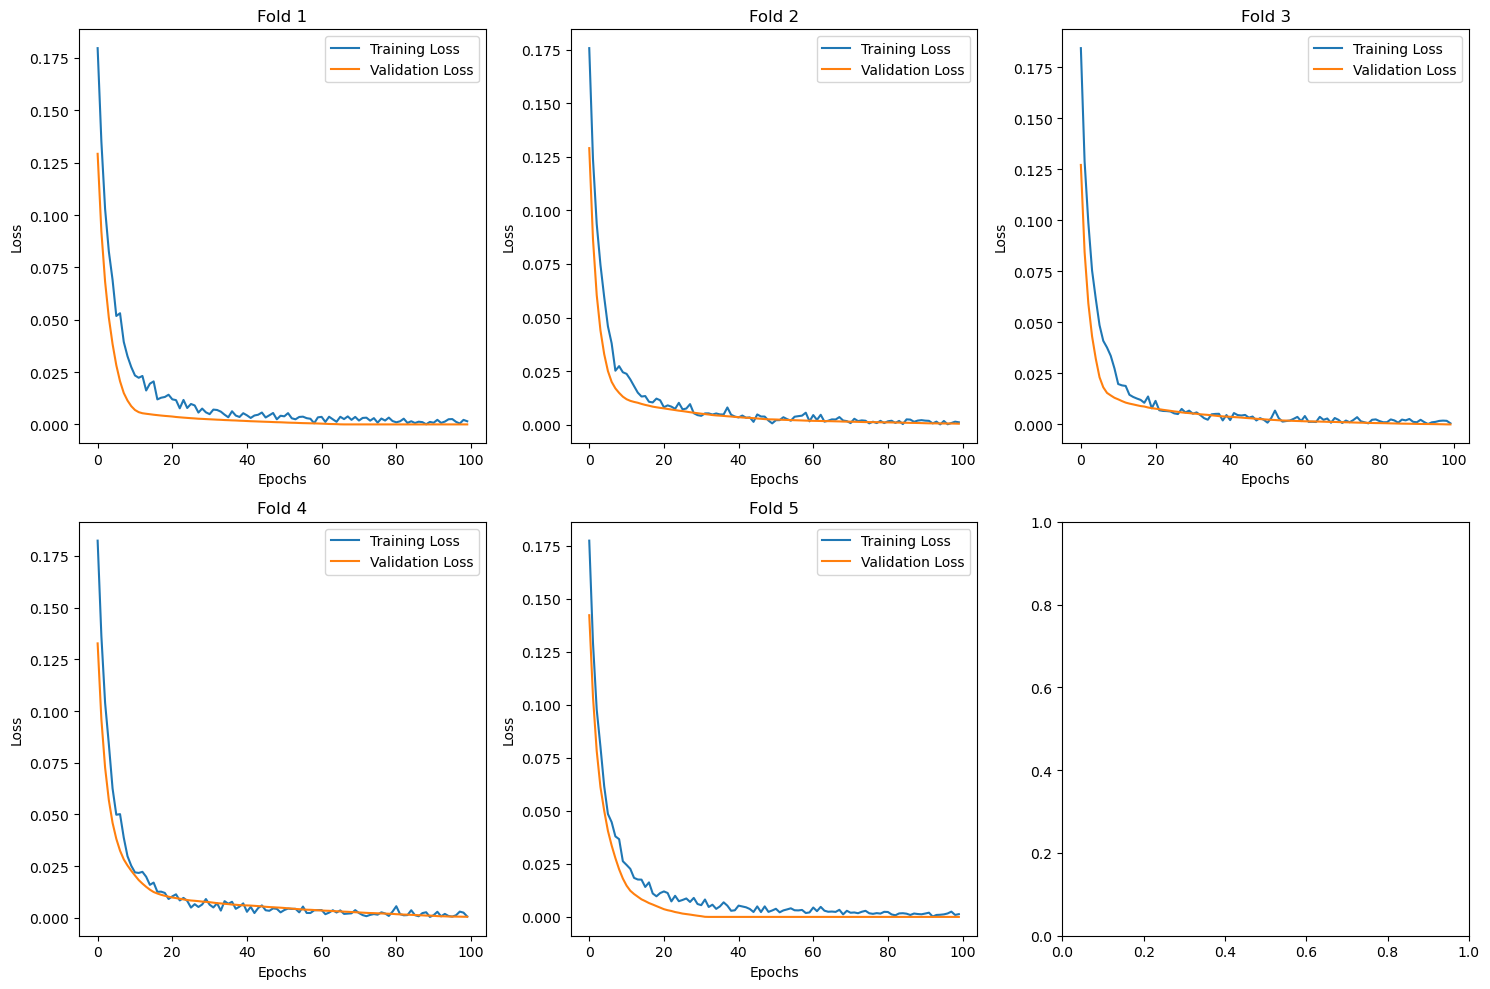

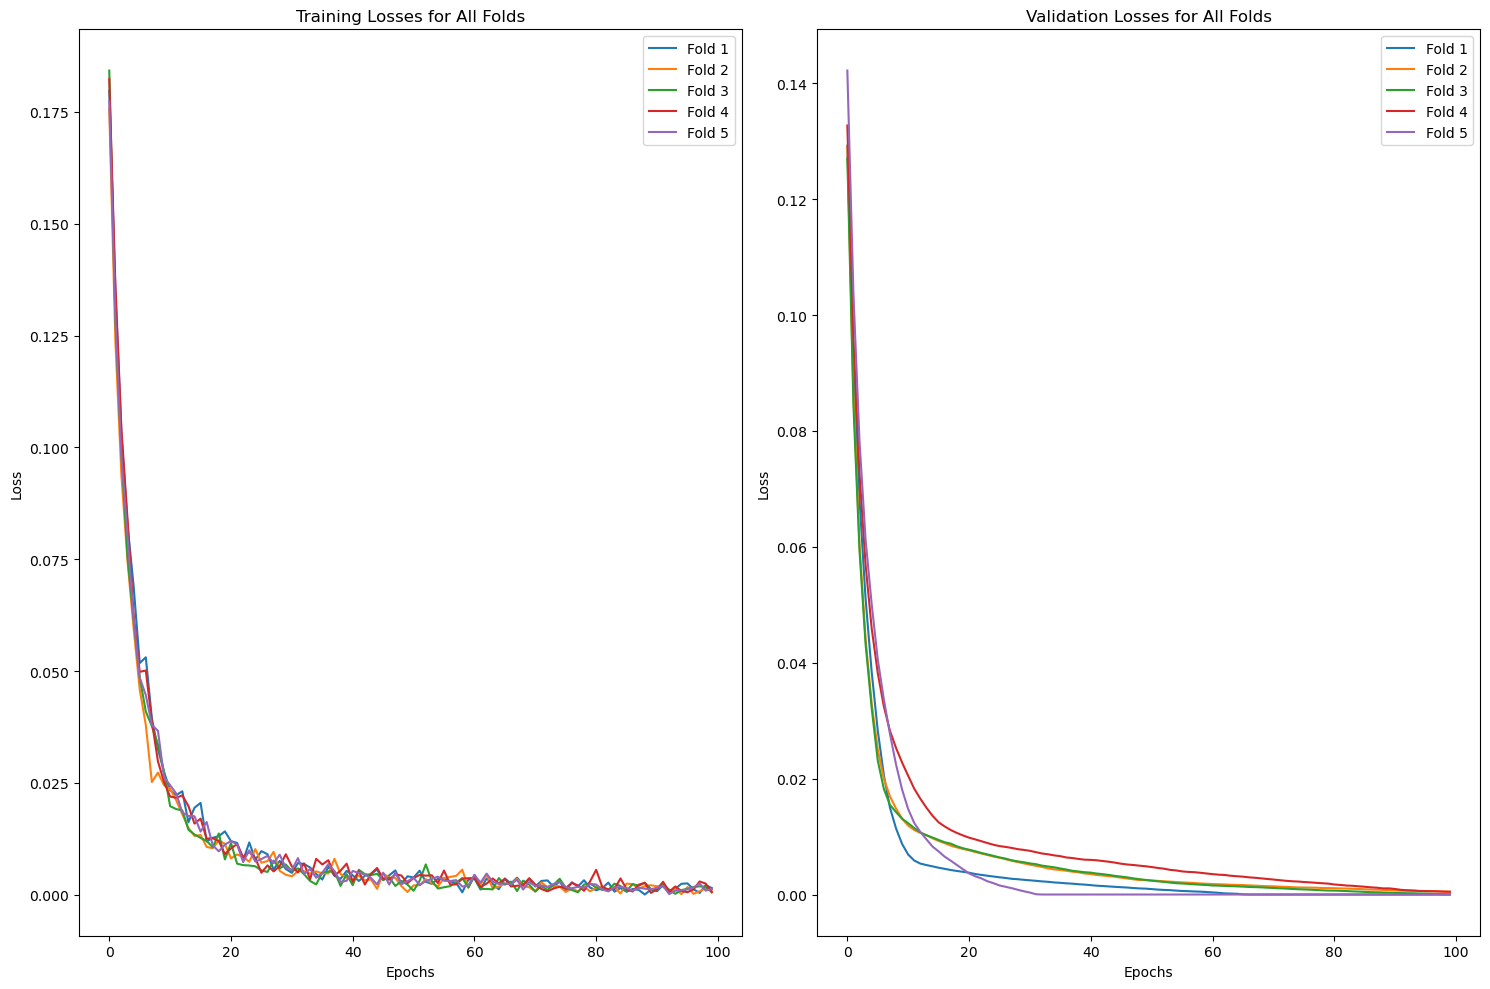

Best model index: 1, Best validation RMSE: 0.000
Deleted: best_model_fold_0.keras
Deleted: best_model_fold_2.keras
Deleted: best_model_fold_3.keras
Deleted: best_model_fold_4.keras


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │       128,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,356 (517.02 KB)

 Trainable params: 132,354 (517.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [17]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
from keras.callbacks import EarlyStopping

# Assuming you have defined X_train_vect, scaled_labels_train, and rmse_custom

# 5-Fold Cross Validation performing on the training set
rmseTrain = []
rmseValidation = []
rmse1 = []

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create subplots with 3 columns and 2 rows
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

best_val_loss = float('inf')  # Initialize with a very large value
best_model_weights = None  # Initialize with None
best_model_index = None  # Initialize with None

stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15, restore_best_weights=True)

for i, (train, test) in enumerate(kfold.split(X_train_vect)):
    X_train_fold, X_test_fold = X_train_vect[train], X_train_vect[test]
    y_train_fold, y_test_fold = scaled_labels_train[train], scaled_labels_train[test]

    # Define the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_vect.shape[1], activation='tanh'))
    model.add(Dropout(0.8))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    # Compile the model with SGD optimizer
    optimizer = SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
    model.compile(loss=rmse_custom, optimizer=optimizer)

    # Callback to save best model weights
    checkpoint = ModelCheckpoint(filepath=f"best_model_fold_{i}.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # Fit the model
    history = model.fit(X_train_fold,
                        y_train_fold,
                        validation_data=(X_test_fold, y_test_fold),
                        epochs=100, 
                        batch_size=32, 
                        verbose=0,
                        callbacks=[checkpoint])  # Add the checkpoint callback

    # Plot the loss
    row_index = i // 3  # Calculate the row index for the subplot
    col_index = i % 3   # Calculate the column index for the subplot
    axs[row_index, col_index].plot(history.history['loss'], label='Training Loss')
    axs[row_index, col_index].plot(history.history['val_loss'], label='Validation Loss')
    axs[row_index, col_index].set_title(f'Fold {i+1}')
    axs[row_index, col_index].set_xlabel('Epochs')
    axs[row_index, col_index].set_ylabel('Loss')
    axs[row_index, col_index].legend()

    # Evaluate the model
    val_loss = history.history['val_loss'][-1]  # Get the validation loss from the last epoch
    vallos = history.history['val_loss']
    rmse1.append(vallos)
    rmseValidation.append(val_loss)
    print(f'Fold: {i+1}, Validation RMSE: {val_loss:.3f}')

    # Check if current model has the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_index = i

    # Store training loss
    rmseTrain.append(history.history['loss'])

plt.tight_layout()
plt.show()

fig1, axs1 = plt.subplots(1, 2, figsize=(15, 10))

# Plot all training losses

for i in range(len(rmseTrain)):
    axs1[0].plot(rmseTrain[i], label=f'Fold {i+1}')
axs1[0].set_title('Training Losses for All Folds')
axs1[0].set_xlabel('Epochs')
axs1[0].set_ylabel('Loss')
axs1[0].legend()



for i in range(len(rmseValidation)):
    axs1[1].plot(rmse1[i], label=f'Fold {i+1}')
axs1[1].set_title('Validation Losses for All Folds')
axs1[1].set_xlabel('Epochs')
axs1[1].set_ylabel('Loss')
axs1[1].legend()
plt.tight_layout()
plt.show()


# Load the best model weights
best_model = Sequential()
best_model.add(Dense(64, input_dim=X_train_vect.shape[1], activation='tanh'))
best_model.add(Dropout(0.8))
best_model.add(Dense(64, activation='tanh'))
best_model.add(Dropout(0.2))
best_model.add(Dense(2, activation='linear'))

# Load the weights of the best model
best_model.load_weights(f"best_model_fold_{best_model_index}.keras")

opt = SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
best_model.compile(loss=rmse_custom, optimizer=opt)

best_model.fit(X_train_vect, scaled_labels_train, epochs=10, batch_size=32, verbose=0)

# Now best_model contains the weights and biases corresponding to the best fold
print(f'Best model index: {best_model_index+1}, Best validation RMSE: {best_val_loss:.3f}')

# Delete other model files
for i in range(0, 5): 
    if i != best_model_index + 1:
        file_path = f"best_model_fold_{i}.keras"
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")

best_model.summary()


In [18]:
best_model.evaluate(X_test_vect, scaled_labels_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 5.3360e-04


0.0009284703410230577

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Overall Mean Loss: 0.887


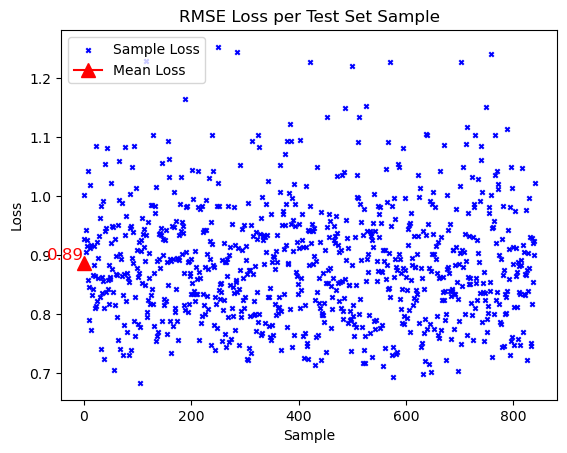

In [19]:
# Get predictions for the test set
predictions = best_model.predict(X_test_vect)

# Calculate loss for each sample
sample_losses = np.sqrt(np.mean(np.square(predictions - scaled_labels_test), axis=1))

# Calculate overall mean loss
mean_loss = np.mean(sample_losses)

print(f'Overall Mean Loss: {mean_loss:.3f}')


# plt.plot(sample_losses)
plt.scatter(range(len(sample_losses)), sample_losses, s=10, marker='x', color='blue')

# plt.imshow(sample_losses)
plt.plot(mean_loss, marker='^', markersize=10, color='red') 
plt.title('RMSE Loss per Test Set Sample')
plt.xlabel('Sample')
plt.ylabel('Loss')
plt.text(0.5, mean_loss, f'{mean_loss:.2f}', color='red', fontsize=12, ha='right', va='bottom')
plt.legend(['Sample Loss', 'Mean Loss'])
plt.show()


In [20]:
print(f'Took {(time() - time_start) / 60:.2f} minutes!')

Took 0.49 minutes!
